In [2]:
%pip install tensorflow keras
%conda install -c conda-forge opencv
%pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.
Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\Ulises\miniconda3\envs\agriculture_land

  added / updated specs:
    - opencv


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       h56e8100_0         155 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         155 KB

The following packages will be UPDATED:

  ca-certificates                       2024.7.4-h56e8100_0 --> 2024.8.30-h56e8100_0 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main/win-64::certifi-2024.7.4-py~ --> conda-forge/noarch::certifi-2024.7.4-pyhd8ed1ab_

In [3]:
from simple_multi_unet_model import multi_unet_model

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import json
from PIL import Image
from colormap import rgb2hex, hex2rgb
import random
import cv2 as cv

# Classifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import keras
from keras.utils import normalize, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalFocalCrossentropy

import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

import joblib

In [4]:
%pip install skillsnetwork

Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
from zipfile import ZipFile
from io import BytesIO

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/data-science-in-agriculture-land-use-classification/Semantic_segmentation_dataset.zip"

# Download the file
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))

# Extract the contents
zip_file.extractall("")


In [6]:
# Resizing images if needed
size_x = 256
size_y = 256
n_classes = 6

In [7]:
def get_data(folder, file):
    # download json
    f = open(folder + "/" + file,)
    data = json.load(f)
    f.close()
    cl = {}
    
    # Create a dictionary with classes
    for i, c in enumerate(data['classes']):
        cl[i] = dict(c)
        
    # Capture training image info as a list
    train_images = []
    train_masks = []
    
    for k, v in cl.items():
        print('Class', k)
        for k2, v2 in v.items():
            print("  ", k2, v2)
    
    # download images
    sd = [item for item in os.listdir(folder) if os.path.isdir(folder + '/' +item)] # a list of subdirectories
    print("Subdirectories: ", sd)
    
    for f in sd[1:9]: #choose one of the subdirectories to download
        print("Downloading: ", f)
        images = glob(folder + "/" + f + "/images" + "/*.jpg") # create a list of image files
        for im in images:
            msk = im.replace("images", "masks").replace("jpg", "png") # create a list of mask files
            image = cv.imread(im, 1)
            mask = cv.imread(msk, 1)
            # Resizing with cv 256 x 256 x 3 pixels
            #image = cv.resize(image, (size_x, size_y), interpolation = cv.INTER_NEAREST)
            #mask = cv.resize(mask, (size_x, size_y), interpolation = cv.INTER_NEAREST)
            # Debugging print statements
            image_array = np.array(image)
            mask_array = np.array(mask)
            print(f"Processing image: {im}")
            print(f"Mask shape: {mask_array.shape}, and Image shape: {image_array.shape}")
            print(f"Mask array dimensions: {len(mask_array.shape)}, and Image array dim: {len(image_array.shape)}")
            
            if len(mask_array.shape) >= 2:
                print("Appending image and mask to data list.")
                train_images.append(image)
                train_masks.append(mask)
            else:
                print("Mask is not colored (does not have more than 2 dimensions). Skipping.")
        fig = plt.figure(figsize= (10, 10)) # display last image + mask
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.subplot(1,2,2)
        plt.imshow(mask)
        plt.show()
    
    return train_images, train_masks

Class 0
   title Water
   shape polygon
   color #50E3C2
   geometry_config {}
Class 1
   title Land (unpaved area)
   shape polygon
   color #F5A623
   geometry_config {}
Class 2
   title Road
   shape polygon
   color #DE597F
   geometry_config {}
Class 3
   title Building
   shape polygon
   color #D0021B
   geometry_config {}
Class 4
   title Vegetation
   shape polygon
   color #417505
   geometry_config {}
Class 5
   title Unlabeled
   shape polygon
   color #9B9B9B
   geometry_config {}
Subdirectories:  ['Tile 1', 'Tile 2', 'Tile 3', 'Tile 4', 'Tile 5', 'Tile 6', 'Tile 7', 'Tile 8']
Downloading:  Tile 2
Processing image: Semantic segmentation dataset/Tile 2/images\image_part_001.jpg
Mask shape: (544, 509, 3), and Image shape: (544, 509, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 2/images\image_part_002.jpg
Mask shape: (544, 510, 3), and Image shape: (544, 510, 3)
Mask array dimen

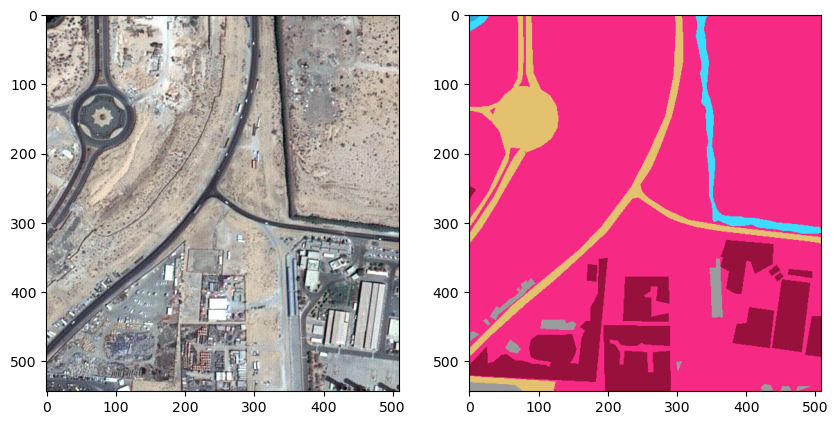

Downloading:  Tile 3
Processing image: Semantic segmentation dataset/Tile 3/images\image_part_001.jpg
Mask shape: (658, 682, 3), and Image shape: (658, 682, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 3/images\image_part_002.jpg
Mask shape: (658, 682, 3), and Image shape: (658, 682, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 3/images\image_part_003.jpg
Mask shape: (658, 682, 3), and Image shape: (658, 682, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 3/images\image_part_004.jpg
Mask shape: (658, 682, 3), and Image shape: (658, 682, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 3/images\image_par

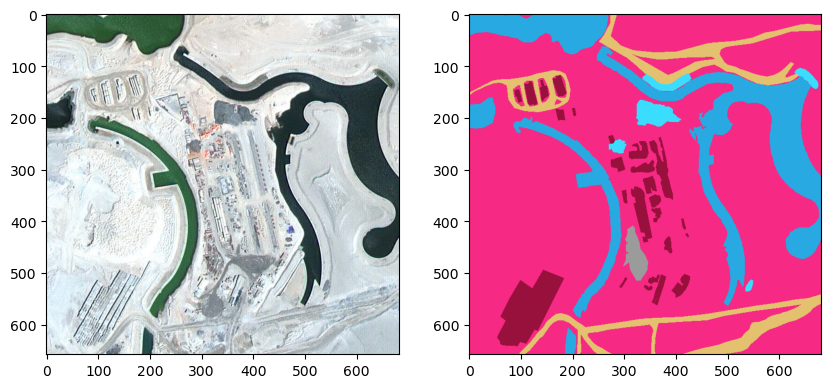

Downloading:  Tile 4
Processing image: Semantic segmentation dataset/Tile 4/images\image_part_001.jpg
Mask shape: (846, 1099, 3), and Image shape: (846, 1099, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 4/images\image_part_002.jpg
Mask shape: (846, 1099, 3), and Image shape: (846, 1099, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 4/images\image_part_003.jpg
Mask shape: (846, 1099, 3), and Image shape: (846, 1099, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 4/images\image_part_004.jpg
Mask shape: (846, 1099, 3), and Image shape: (846, 1099, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 4/images\i

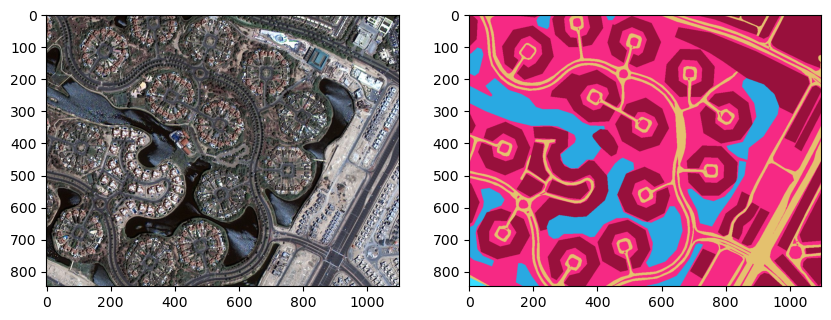

Downloading:  Tile 5
Processing image: Semantic segmentation dataset/Tile 5/images\image_part_001.jpg
Mask shape: (1058, 1126, 3), and Image shape: (1058, 1126, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 5/images\image_part_002.jpg
Mask shape: (1058, 1126, 3), and Image shape: (1058, 1126, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 5/images\image_part_003.jpg
Mask shape: (1058, 1126, 3), and Image shape: (1058, 1126, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 5/images\image_part_004.jpg
Mask shape: (1058, 1126, 3), and Image shape: (1058, 1126, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 5/

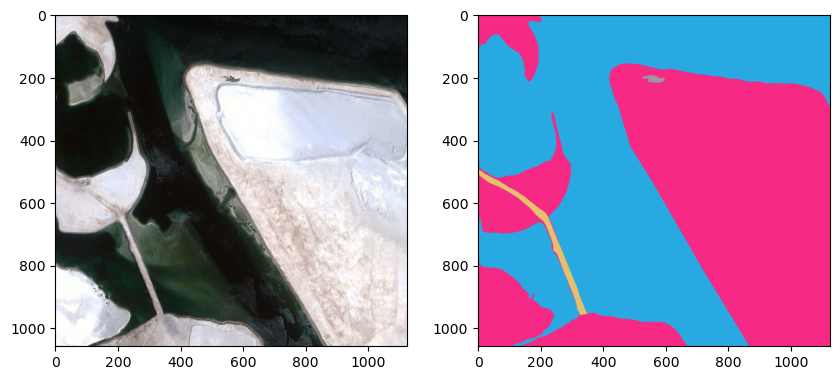

Downloading:  Tile 6
Processing image: Semantic segmentation dataset/Tile 6/images\image_part_001.jpg
Mask shape: (838, 859, 3), and Image shape: (838, 859, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 6/images\image_part_002.jpg
Mask shape: (838, 859, 3), and Image shape: (838, 859, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 6/images\image_part_003.jpg
Mask shape: (838, 859, 3), and Image shape: (838, 859, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 6/images\image_part_004.jpg
Mask shape: (838, 859, 3), and Image shape: (838, 859, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 6/images\image_par

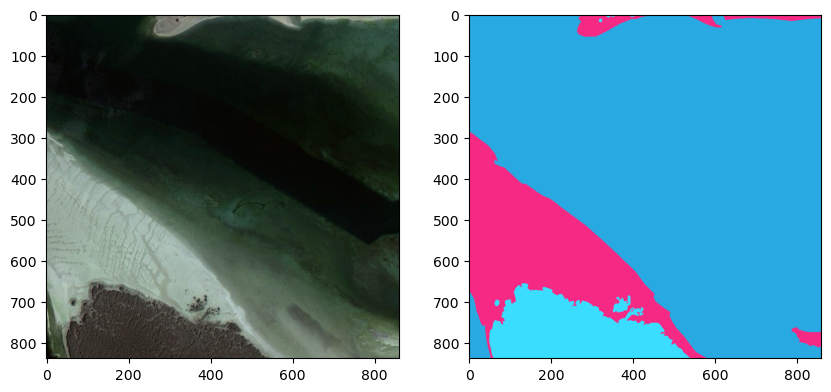

Downloading:  Tile 7
Processing image: Semantic segmentation dataset/Tile 7/images\image_part_001.jpg
Mask shape: (2061, 1817, 3), and Image shape: (2061, 1817, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 7/images\image_part_002.jpg
Mask shape: (2061, 1816, 3), and Image shape: (2061, 1816, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 7/images\image_part_003.jpg
Mask shape: (2061, 1817, 3), and Image shape: (2061, 1817, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 7/images\image_part_004.jpg
Mask shape: (2062, 1817, 3), and Image shape: (2062, 1817, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 7/

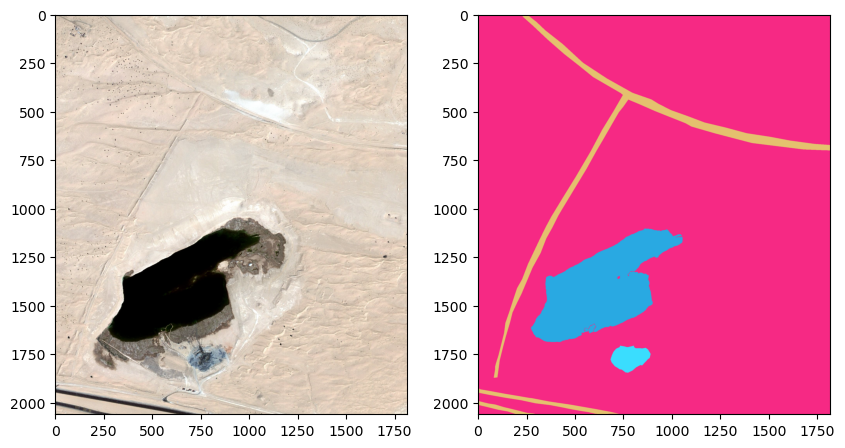

Downloading:  Tile 8
Processing image: Semantic segmentation dataset/Tile 8/images\image_part_001.jpg
Mask shape: (1479, 2149, 3), and Image shape: (1479, 2149, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 8/images\image_part_002.jpg
Mask shape: (1479, 2149, 3), and Image shape: (1479, 2149, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 8/images\image_part_003.jpg
Mask shape: (1479, 2149, 3), and Image shape: (1479, 2149, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 8/images\image_part_004.jpg
Mask shape: (1480, 2149, 3), and Image shape: (1480, 2149, 3)
Mask array dimensions: 3, and Image array dim: 3
Appending image and mask to data list.
Processing image: Semantic segmentation dataset/Tile 8/

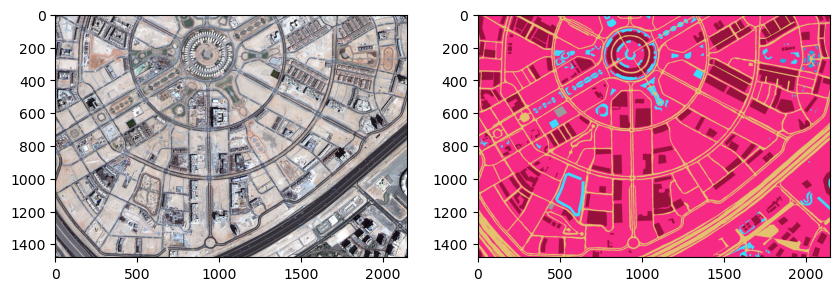

In [8]:
train_images, train_masks = get_data("Semantic segmentation dataset", "classes.json")

In [9]:
def crop_image(image, mask, crop_size):
    """
    Crops the image and mask into smaller patches of size crop_size x crop_size.
    
    Args:
    - image: The input image to be cropped.
    - mask: The corresponding mask to be cropped.
    - crop_size: The size (width and height) of each crop.
    
    Returns:
    - cropped_images: A list of cropped image patches.
    - cropped_masks: A list of cropped mask patches.
    """
    img_height, img_width = image.shape[:2]
    cropped_images = []
    cropped_masks = []

    for y in range(0, img_height, crop_size):
        for x in range(0, img_width, crop_size):
            # Ensure that the crop is within the image dimensions
            if y + crop_size <= img_height and x + crop_size <= img_width:
                cropped_image = image[y:y+crop_size, x:x+crop_size]
                cropped_mask = mask[y:y+crop_size, x:x+crop_size]
                cropped_images.append(cropped_image)
                cropped_masks.append(cropped_mask)

    return cropped_images, cropped_masks

In [10]:
# Example usage of the cropping function
crop_size = 256  # Desired size for the crops

# Initialize lists to store the cropped images and masks
all_cropped_images = []
all_cropped_masks = []

for img, msk in zip(train_images, train_masks):
    cropped_imgs, cropped_msks = crop_image(img, msk, crop_size)
    all_cropped_images.extend(cropped_imgs)
    all_cropped_masks.extend(cropped_msks)

# Convert the lists to numpy arrays for further processing
train_images = np.array(all_cropped_images)
train_masks = np.array(all_cropped_masks)

print(f"Total cropped images: {len(train_images)}")
print(f"Total cropped masks: {len(train_masks)}")

Total cropped images: 1251
Total cropped masks: 1251


In [11]:
def get_unique_colors(masks):
    # Reshape the masks array to a 2D array where each row is an RGB triplet
    reshaped_masks = masks.reshape(-1, masks.shape[-1])
    
    # Get unique rows (unique RGB colors)
    unique_colors = np.unique(reshaped_masks, axis=0)
    
    return unique_colors

In [12]:
# Assuming train_masks is a list of mask arrays
train_masks_array = np.array(train_masks)  # Convert to numpy array

# Extract unique colors from all masks
unique_colors = get_unique_colors(train_masks_array)

# Print unique colors
print("Unique RGB colors in the masks:")
for color in unique_colors:
    print(color)

Unique RGB colors in the masks:
[0 0 0]
[ 41 169 226]
[ 58 221 254]
[152  16  60]
[155 155 155]
[228 193 110]
[246  41 132]


In [13]:
hex_labels = [[ 0, 'water', '#50E3C2'],
              [1, 'land', '#F5A623'],
              [2, 'road', '#DE597F'],
              [3, 'building', '#D0021B'],
              [4, 'vegetation', '#417505'],
              [5, 'unlabeled', '#9B9B9B']]

rgb_labels = [[ 0, 'water', 80, 227, 194],
              [1, 'land', 245, 166, 35],
              [2, 'road', 222, 89, 127],
              [3, 'building', 208, 2, 27],
              [4, 'vegetation', 65, 117, 5],
              [5, 'unlabeled', 155, 155, 155]]

# Define RGB to class mapping, including a mapping for black pixels
rgb_to_class = {
    (0, 0, 0): 5,         # Black pixels as background or ignored class
    (41, 169, 226): 0,    # Water
    (58, 221, 254): 1,    # Land
    (152, 16, 60): 2,     # Road
    (228, 193, 110): 3,   # Building
    (246, 41, 132): 4,    # Vegetation
    (155, 155, 155): 5    # Unlabeled
}



In [14]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

print(train_masks.shape)
print(train_images.shape)

(1251, 256, 256, 3)
(1251, 256, 256, 3)


In [15]:
def rgb_to_class_conversion(mask, rgb_to_class):
    # Initialize an empty array for the class labels
    class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)  # Default to class 0
    
    # Iterate through the RGB-to-class mapping and replace RGB values with class labels
    for rgb, class_label in rgb_to_class.items():
        match_pixels = (mask == rgb).all(axis=-1)  # Find pixels that match the current RGB value
        class_mask[match_pixels] = class_label     # Assign the corresponding class label
    
    return class_mask

# Initialize an empty list to store converted masks
converted_masks = []

# Loop through each mask in the batch
for mask in train_masks:
    converted_mask = rgb_to_class_conversion(mask, rgb_to_class)
    converted_masks.append(converted_mask)

# Convert the list of converted masks back to a numpy array
converted_masks_array = np.array(converted_masks)

# Print the unique class labels in the converted masks
print("Unique class labels in the converted masks:")
print(np.unique(converted_masks_array))



Unique class labels in the converted masks:
[0 1 2 3 4 5]


In [16]:
converted_masks_array.shape

(1251, 256, 256)

In [17]:
train_images.shape

(1251, 256, 256, 3)

In [18]:
# train_images = np.expand_dims(train_images, axis=3) # Only add this line if images are greyscale instead of RGB
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(converted_masks_array, axis=3)

In [19]:
train_images.shape

(1251, 256, 256, 3)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=42)

#X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size=0.2, random_state=42) #Optional to make the dataset smaller

In [21]:
print("Class values in the dataset are ...", np.unique(y_train))

Class values in the dataset are ... [0 1 2 3 4 5]


**Train and test masks converted to categorical**

In [22]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes)) # In this case, this should exactly be the same

In [23]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes)) # In this case, this should exactly be the same

**Class weights**

We compute class weights because our dataset is heavily unbalanced, there are some colors that are much more frequent in pixels than others

In [87]:
class_weights_array = class_weight.compute_class_weight(class_weight='balanced',
                                     classes=np.unique(converted_masks_array),
                                     y=converted_masks_array.flatten())

# Convert to dictionary
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

print("Class weights are:", class_weights)



Class weights are: {0: 1.2880170470537822, 1: 1.5954124345264415, 2: 1.227241888401039, 3: 1.813370222906057, 4: 0.31531500888399083, 5: 16.923544514503767}


In [88]:
# Define a custom loss function like Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0  # Smoothing factor
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [89]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


def get_model():
    return multi_unet_model(n_classes=n_classes,
                            IMG_HEIGHT=IMG_HEIGHT,
                            IMG_WIDTH=IMG_WIDTH,
                            IMG_CHANNELS=IMG_CHANNELS)
model = get_model()
model.compile(optimizer='adam', loss=keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 16)         448       ['input_6[0][0]']             
                                                                                                  
 dropout_45 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_95[0][0]']           
                                                                                                  
 conv2d_96 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_45[0][0]']          
                                                                                            

In [90]:
X_train.shape

(1125, 256, 256, 3)

In [91]:
y_train_cat.shape

(1125, 256, 256, 6)

In [58]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with various augmentations
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to the data
datagen.fit(X_train)

In [93]:
# Use the augmented data in model training
history = model.fit(X_train, y_train_cat,
                    batch_size=32,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test_cat),
                    class_weight=class_weights,
                    shuffle=False)


Epoch 1/50
36/36 [==============================] - 311s 7s/step - loss: 0.3038 - accuracy: 0.3195 - val_loss: 0.2960 - val_accuracy: 0.2625
Epoch 2/50
36/36 [==============================] - 247s 7s/step - loss: 0.2857 - accuracy: 0.2749 - val_loss: 0.2858 - val_accuracy: 0.5019
Epoch 3/50
36/36 [==============================] - 249s 7s/step - loss: 0.2662 - accuracy: 0.2720 - val_loss: 0.2731 - val_accuracy: 0.5276
Epoch 4/50
36/36 [==============================] - 249s 7s/step - loss: 0.2566 - accuracy: 0.4047 - val_loss: 0.2740 - val_accuracy: 0.4997
Epoch 5/50
36/36 [==============================] - 247s 7s/step - loss: 0.2486 - accuracy: 0.5087 - val_loss: 0.2456 - val_accuracy: 0.5580
Epoch 6/50
36/36 [==============================] - 247s 7s/step - loss: 0.2353 - accuracy: 0.5699 - val_loss: 0.2242 - val_accuracy: 0.5594
Epoch 7/50
36/36 [==============================] - 248s 7s/step - loss: 0.2171 - accuracy: 0.5904 - val_loss: 0.1953 - val_accuracy: 0.6202
Epoch 8/50
36

In [94]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

4/4 [==============================] - 4s 966ms/step - loss: 0.0817 - accuracy: 0.7896
Accuracy is =  78.96245121955872 %


In [96]:
model.save('models/land_segmentation_unet_50epochs_ClassWeights_Bsize32_adam_categoricalfocal_FULL_resolution.keras')

In [29]:
model = load_model(
    'models/land_segmentation_unet_50epochs_ClassWeights_Bsize32_adam_categoricalfocal_FULL_resolution.keras', compile=False)

In [30]:
# Recompile the U-Net model with the original loss function
model.compile(
    optimizer=Adam(), loss=CategoricalFocalCrossentropy(), metrics=['accuracy']
)

In [31]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

4/4 [==============================] - 5s 1s/step - loss: 0.0817 - accuracy: 0.7896
Accuracy is =  78.96245121955872 %


In [1]:
# Assuming images were normalized to the range [0, 1]
def denormalize_image(image):
    # Rescale back to [0, 255]
    image = image - image.min()  # Shift to have a minimum of 0
    image = image / image.max()  # Normalize to have a maximum of 1
    return (image * 255).astype(np.uint8)


# Function to convert class labels back to RGB
def class_to_rgb_conversion(mask, class_to_rgb):
    # Initialize an empty array for the RGB image
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    # Iterate through the class-to-RGB mapping and replace class labels with RGB values
    for class_label, rgb in class_to_rgb.items():
        rgb_image[mask == class_label] = rgb
    
    return rgb_image

# Define the class-to-RGB mapping (reverse of your RGB-to-class mapping)
class_to_rgb = {v: k for k, v in rgb_to_class.items()}

# Select an image and mask from the test dataset
idx = 6  # Change this index to select a different test image
input_image = X_test[idx]
true_mask = y_test[idx]

# Denormalize the input image
denormalized_image = denormalize_image(input_image)

# Make prediction
predicted_mask = model.predict(np.expand_dims(input_image, axis=0))
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Get the class label for each pixel

# Convert true and predicted masks back to RGB
true_mask_rgb = class_to_rgb_conversion(true_mask[:, :, 0], class_to_rgb)
predicted_mask_rgb = class_to_rgb_conversion(predicted_mask, class_to_rgb)

# Plot the original image, true mask, and predicted mask
plt.figure(figsize=(15, 5))

# Plot the denormalized original image
plt.subplot(1, 3, 1)
plt.imshow(denormalized_image)
plt.title('Original Image (Denormalized)')

# Plot the true mask
plt.subplot(1, 3, 2)
plt.imshow(true_mask_rgb)
plt.title('True Mask')

# Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_rgb)
plt.title('Predicted Mask')

plt.show()



NameError: name 'rgb_to_class' is not defined

4/4 [==============================] - 4s 897ms/step


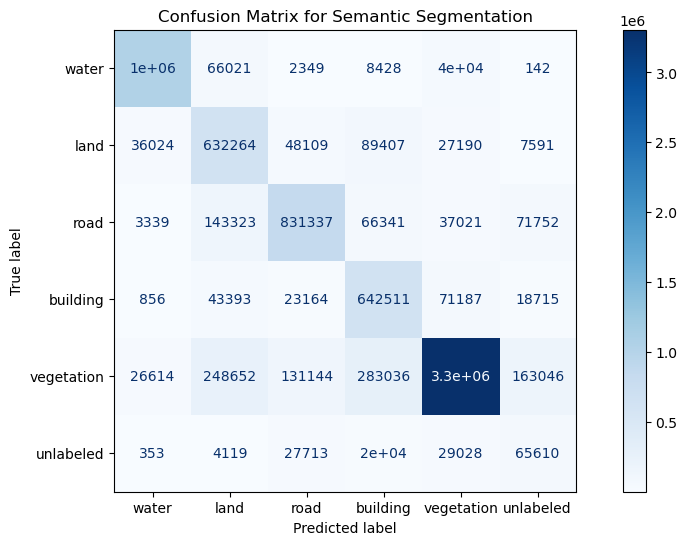

In [36]:
# Flatten the true and predicted masks
y_true_flat = y_test_cat.argmax(axis=-1).flatten()  # Flatten true mask to 1D array
y_pred_flat = model.predict(X_test).argmax(axis=-1).flatten()  # Predict and flatten to 1D array

# Calculate the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(n_classes))

# Set figure size to make the matrix larger
plt.figure(figsize=(12, 6))  # Adjust the width and height as needed

# Display the confusion matrix with larger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label[1] for label in hex_labels])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Use current axes to apply the figure size
plt.title("Confusion Matrix for Semantic Segmentation")
plt.show()

In [52]:
# Reminder
rgb_to_class = {
    (0, 0, 0): 5,         # Black pixels as background or ignored class
    (41, 169, 226): 0,    # Water
    (58, 221, 254): 1,    # Land
    (152, 16, 60): 2,     # Road
    (228, 193, 110): 3,   # Building
    (246, 41, 132): 4,    # Vegetation
    (155, 155, 155): 5    # Unlabeled
}

# Logistic Regression

In [47]:
# Reduce the number of images for training to 100 (or any other smaller number)
reduced_size = 200  # Adjust this number as needed

# Use train_test_split to randomly select a subset of 100 images
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, train_size=reduced_size, test_size= 0.03, random_state=42)

# Flatten the reduced images and labels for Logistic Regression / RandomForest input
X_train_small_flat = X_train_small.reshape((X_train_small.shape[0], -1, X_train_small.shape[3]))  # Shape: (100, 256*256, 3)
X_train_small_flat = X_train_small_flat.reshape((-1, X_train_small_flat.shape[-1]))  # Shape: (100*256*256, 3)

y_train_small_flat = y_train_small.reshape((y_train_small.shape[0], -1)).flatten()  # Shape: (100*256*256,)

# Flatten the reduced images and labels for Logistic Regression / RandomForest input
X_test_small_flat = X_test_small.reshape((X_test_small.shape[0], -1, X_test_small.shape[3]))  # Shape: (100, 256*256, 3)
X_test_small_flat = X_test_small_flat.reshape((-1, X_test_small_flat.shape[-1]))  # Shape: (100*256*256, 3)

y_test_small_flat = y_test_small.reshape((y_test_small.shape[0], -1)).flatten()  # Shape: (100*256*256,)



# Display the shapes
print("Reduced X_train_flat shape:", X_train_small_flat.shape)  # (100*256*256, 3)
print("Reduced y_train_flat shape:", y_train_small_flat.shape)  # (100*256*256,)

# Display the shapes
print("Reduced X_test_flat shape:", X_test_small_flat.shape)  # (100*256*256, 3)
print("Reduced y_test_flat shape:", y_test_small_flat.shape)  # (100*256*256,)

X_train_lr = pd.DataFrame(X_train_small_flat)
y_train_lr = pd.DataFrame(y_train_small_flat)
X_test_lr = pd.DataFrame(X_test_small_flat)
y_test_lr = pd.DataFrame(y_test_small_flat)

y_train_lr[0]


Reduced X_train_flat shape: (13107200, 3)
Reduced y_train_flat shape: (13107200,)
Reduced X_test_flat shape: (2228224, 3)
Reduced y_test_flat shape: (2228224,)


0           4
1           4
2           4
3           4
4           4
           ..
13107195    4
13107196    4
13107197    4
13107198    0
13107199    0
Name: 0, Length: 13107200, dtype: int32

In [48]:
lr_balanced = LogisticRegression(max_iter=100, n_jobs=-1, class_weight='balanced')
lr_balanced.fit(X_train_small_flat, y_train_small_flat)

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [49]:
scores_train = lr_balanced.score(X_train_small_flat, y_train_small_flat)
scores_test = lr_balanced.score(X_train_small_flat, y_train_small_flat)

print('Accuracy train DataSet: {: .1%}'.format(scores_train), 'Accuracy test DataSet: {: .1%}'.format(scores_test))

Accuracy train DataSet:  27.7% Accuracy test DataSet:  27.7%
